In [1]:
import subprocess, os
import re
import pandas as pd
import ijson
import time

fileType1= 't1.json'
fileType2= 't2.json'
fileType3= 't3.json'
LINUX='/home/anil-mint-desktop/linux-stable'
HOME='/home/anil-mint-desktop/patchstudy/test/datasets/ds'

from operator import itemgetter
from itertools import groupby

def calculatePatchSize(minusIndex, plusIndex):
    data = sorted(minusIndex + plusIndex)
    total = 0
    for k, g in groupby(enumerate(data), lambda (i,x):i-x):
        tmp =  map(itemgetter(1), g)
        #print(tmp)  
        count = 0
        for e in tmp:
            if e in minusIndex:
                count -= 1
            if e in plusIndex:
                count += 1

        if(count == 0):
            count = len(tmp) /2
        if count < 0:
            count *= -1
        if( len(tmp) != count):
            count = (len(tmp) + count) /2
        total += count 
        #print(count)

    return (total)

def controlReverts(sha):

    os.chdir(LINUX)
    cmd ='git diff -U0 '+sha+'^..'+sha
  
   
    #print(cmd)
    tmp = os.popen(cmd).readlines()
    
    patternHunk = re.compile(r'^@@')
    patternMinusDiscard = re.compile(r'^\-{3}')
    patternMinus = re.compile(r'^\-{1}')
    patternPlusDiscard = re.compile(r'^\+{3}')
    patternPlus = re.compile(r'^\+{1}')
    plusIndex = list()
    minusIndex = list()

    plus = 0
    minus = 0
    hunks = 0
    fileN = 0

    for l in range(len(tmp)):
        #print(l,tmp[l])
        match = (re.search(patternHunk,tmp[l]))
        if match:
            hunks += 1

        match = (re.search(patternPlusDiscard,tmp[l]))
        if not match:
            match = (re.search(patternPlus,tmp[l]))
            if match:
                plus += 1
                plusIndex.append(l)

        match = (re.search(patternMinusDiscard,tmp[l]))
        if not match:
            match = (re.search(patternMinus,tmp[l]))
            if match:
                minus +=1
                minusIndex.append(l)
        else:
            fileN += 1
            
    #print(len(plus))
    #print(len(minus))
    #print(len(hunks))
    
    #print(minusIndex)
    #print(plusIndex)
    return tmp, plusIndex ,minusIndex, hunks, fileN

def datasetReader(filename):
    with open(filename, 'r') as f:
        objects = ijson.items(f,'item' )
        rows = list(objects)
    #print(rows[0])
    return rows

def prepareDataFrame(ds ):
    commits = pd.DataFrame.from_dict(ds)
    df = commits["commit"].values
    return df

FOLDERT1 = '/home/anil-mint-desktop/patchstudy/test/datasets/ds/t/t1'
FOLDERT2 = '/home/anil-mint-desktop/patchstudy/test/datasets/ds/t/t2'
FOLDERT3 = '/home/anil-mint-desktop/patchstudy/test/datasets/ds/t/t3'
def write2File(sha,plusIndex, minusIndex, t ,folder):
    os.chdir(folder )
    s = ''
    for i in plusIndex:
        s += (t[i].split('+')[1])
    s += '\n'
    for i in minusIndex:
        s += (t[i].split('-')[1])
    with open(sha+'.c', 'w') as text_file:
        text_file.write(s)

def saveAll2Files(): 
    
    os.chdir(HOME)
    ds1 = datasetReader(fileType1)
    df1 = prepareDataFrame(ds1)
    print(len(df1))
    ds2 = datasetReader(fileType2)
    df2 = prepareDataFrame(ds2)
    print(len(df2))
    ds3 = datasetReader(fileType3)
    df3 = prepareDataFrame(ds3)
    print(len(df3))
    
    shas1 = dict()
    shas2 = dict()
    shas3 = dict()
    print(time.ctime(time.time()))
    for sha in df1:
        #print(sha)
        t, plusIndex ,minusIndex, hunks ,fileN = controlReverts(sha)
        patchSize = calculatePatchSize(minusIndex, plusIndex)
        shas1[sha] = [hunks, patchSize,fileN]
        #write2File(sha,plusIndex,minusIndex,t, FOLDERT1)'''
    print(time.ctime(time.time()))
    for sha in df2:
        #print(sha)
        t, plusIndex ,minusIndex, hunks, fileN = controlReverts(sha)
        patchSize = calculatePatchSize(minusIndex, plusIndex)
        shas2[sha] = [hunks, patchSize,fileN]
        #write2File(sha,plusIndex,minusIndex,t, FOLDERT2)
    print(time.ctime(time.time()))
    for sha in df3:
        #print(sha)
        t, plusIndex ,minusIndex, hunks, fileN = controlReverts(sha)
        patchSize = calculatePatchSize(minusIndex, plusIndex)
        shas3[sha] = [hunks, patchSize,fileN]
        #write2File(sha,plusIndex,minusIndex,t, FOLDERT3)'''
    return shas1, shas2, shas3
        
def countMethods(typeSha):
    pattern = re.compile(r'\b[0-9a-f]{5,40}\b')
    
    tShas = dict()
    for i in typeSha:
        #print(i)
        match = (re.search(pattern,i))
        if match:
            k= (match.group(0))
            if tShas.has_key(k):
                tShas[k] +=1
            else:
                tShas[k] = 1
    return tShas

def counterForPlot(tShas):
    l = list()
    for i in tShas.itervalues():
        l.append(i)
    #print(l)
    s = set(l)
    tDict = dict()
    #print(s)
    for i in s:        
        tDict[i] =(l.count(i))
    aDict = dict() 
    aDict['2+'] = 0
    for k,v in tDict.iteritems():
        if k == 1 or k == 2:
            aDict[k] = v
        else:
            aDict['2+'] += v
    return aDict

def calculatePercent(tDict, leng):
    
    total = sum(tDict.itervalues(), 0.0)
    tDict[0] = leng - total
    print(tDict[0])
    newy1 = {k: (v*100) / leng for k, v in tDict.iteritems()}

    #print(total)
    print(newy1)
    return newy1

    
        
if __name__ == '__main__': 
    print(time.ctime(time.time()))
    
    a,b,c = saveAll2Files()
    
    print(time.ctime(time.time()))
    
    '''os.chdir(FOLDERT1 )
    
    cmd ='ctags -x --c-types=f *.*' 
    
    print(cmd)
    os.chdir(FOLDERT1 )
    tmp1 = os.popen(cmd).readlines()
    
    t1Shas = countMethods(tmp1)
    
    #print(t1Shas)
    
    print(len(tmp))
    
    os.chdir(FOLDERT2 )
    tmp2 = os.popen(cmd).readlines()
    
    t2Shas = countMethods(tmp2)
    
    print(t2Shas)
    print(len(tmp))
    
    os.chdir(FOLDERT3 )
    tmp3 = os.popen(cmd).readlines()
    
    t3Shas = countMethods(tmp3)
    
    #print(t3Shas)
    
    print(len(tmp))
    
    t1Dict = counterForPlot(t1Shas)
    t2Dict = counterForPlot(t2Shas)
    t3Dict = counterForPlot(t3Shas)
    
    print(t1Dict)
    print(t2Dict)
    print(t3Dict)
    calculatePercent(t1Dict,4050)
    calculatePercent(t2Dict,729)
    calculatePercent(t3Dict,5758)'''

Tue Nov 29 13:48:13 2016
4050
729
5758
Tue Nov 29 13:48:16 2016
Tue Nov 29 13:52:45 2016
Tue Nov 29 13:53:21 2016
Tue Nov 29 13:58:30 2016


In [11]:
import csv
import os

def saveDict2File(aDict, filename):
    w = csv.writer(open(filename, "w"))
    for key, val in aDict.items():
        w.writerow([key, val])

def readFile2Dict(filename):
    dict = {}
    for key, val in csv.reader(open(filename)):
        dict[key] = eval(val)
    return dict

os.chdir(HOME)
saveDict2File(a,'RQ2-compare-locality-a')
saveDict2File(b,'RQ2-compare-locality-b')
saveDict2File(c,'RQ2-compare-locality-c')



                 Files      1      2     3     4    4+
0    Automated Patches  81.73   7.56  3.19  1.90  5.63
1  Semi-manual Patches  86.28   5.49  4.25  0.69  3.29
2       Manual Patches  75.46  11.24  6.48  2.73  4.10
                 Hunks      1      2      3     4     4+
0    Automated Patches  40.79  25.80   7.93  7.26  18.22
1  Semi-manual Patches  35.80  19.07  12.21  6.04  26.89
2       Manual Patches  31.80  18.93  10.73  8.02  30.51
             PatchSize      1      2      3      4     4+
0    Automated Patches  23.14  19.41  12.30  10.22  34.94
1  Semi-manual Patches  22.63  15.36  11.93   6.45  43.62
2       Manual Patches  12.73   7.76   6.23   6.34  66.93


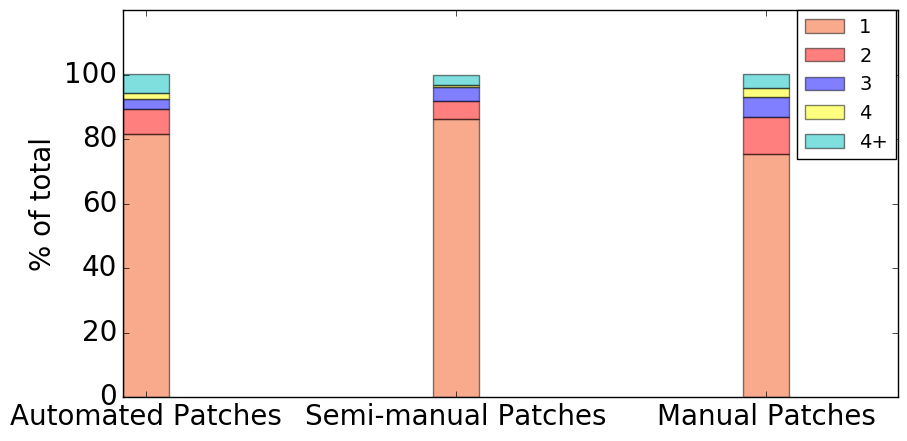

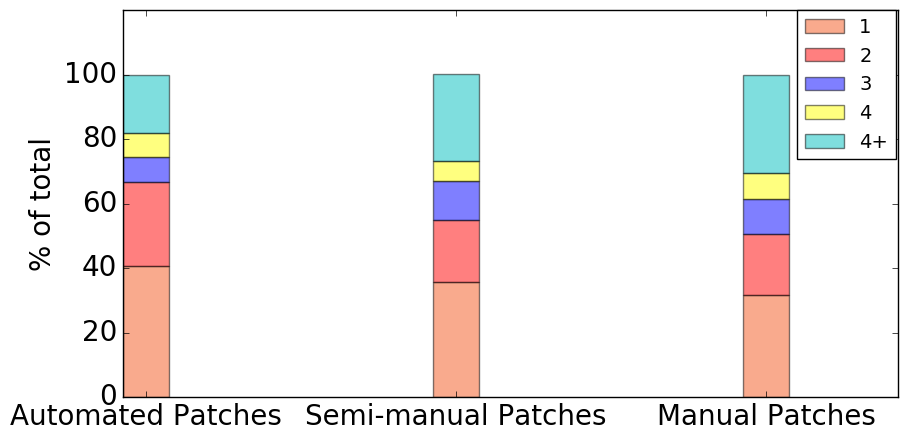

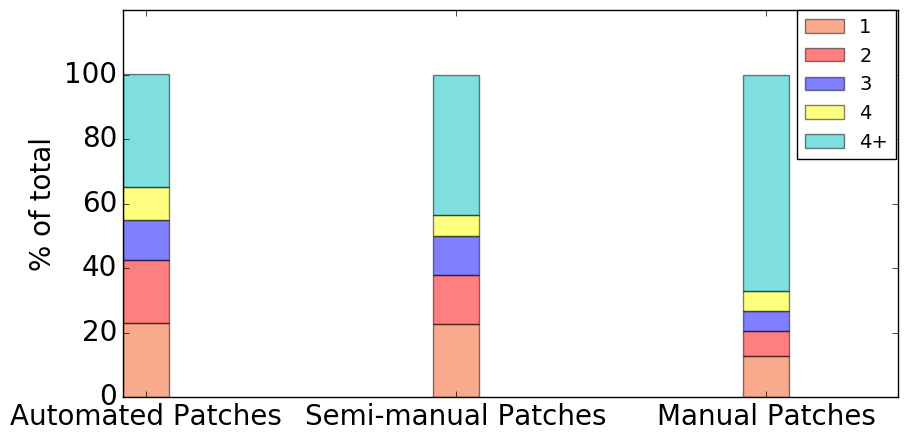

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
# name = 'file'
def readFile2Dict(filename):
    dict = {}
    for key, val in csv.reader(open(filename)):
        dict[key] = eval(val)
    return dict
def plotDist(name , x1, x2, x3 ):

    raw_data = {name: ['Automated Patches','Semi-manual Patches', 'Manual Patches'],
            '1': [x1[1], x2[1], x3[1]],
            '2': [x1[2], x2[2], x3[2]],
            '3': [x1[3], x2[3], x3[3]], 
            '4': [x1[4], x2[4], x3[4]], 
            '4+':[x1['4+'], x2['4+'], x3['4+']]  }
    df = pd.DataFrame(raw_data, columns = [name, '1', '2', '3', '4','4+'])
    print(df)
    plt.figure()
    # Create the general blog and the "subplots" i.e. the bars
    #f, (ax1 ,ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
    
    #f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
    f, ax1  = plt.subplots(1, figsize=(10,5))
    # Set the bar width
    bar_width = 0.15

    # positions of the left bar-boundaries
    bar_l = [i+1 for i in range(len(df['1']))] 
    

    '''print(bar_l)
    bar_l = [1, 1.2, 1.4]
    bar_2 = [2, 2.2, 2.4]
    bar_3 = [3, 3.2, 3.4]'''

    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l] 
    
    
    
    '''tick_pos = [1.025, 1.2249, 1.4249,2.025, 2.2249, 2.4249,3.025, 3.2249, 3.4249]'''

    
    # Create a bar plot, in position bar_1
    ax1.bar(bar_l, 
            # using the pre_score data
            df['1'], 
            # set the width
            width=bar_width,
            # with the label pre score
            label='1', 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='#F4561D')

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l, 
            # using the mid_score data
            df['2'], 
            # set the width
            width=bar_width,
            # with pre_score on the bottom
            bottom=df['1'], 
            # with the label mid score
            label='2', 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='red')

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l, 
            # using the post_score data
            df['3'], 
            # set the width
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=[i+j for i,j in zip(df['1'],df['2'])], 
            # with the label post score
            label='3', 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='blue')

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l, 
            # using the post_score data
            df['4'], 
            # set the width
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=[i+j+k for i,j,k in zip(df['1'],df['2'],df['3'])], 
            # with the label post score
            label='4', 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='yellow')
    ax1.bar(bar_l, 
            # using the post_score data
            df['4+'], 
            # set the width
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=[i+j+k+l for i,j,k,l in zip(df['1'],df['2'],df['3'],df['4'])], 
            # with the label post score
            label='4+', 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='c')
    
   
    # set the x ticks with names
    plt.xticks(tick_pos, df[name], fontsize=20)
    plt.yticks([0,20,40,60,80,100], fontsize=20)

    # Set the label and legends
    ax1.set_ylabel("% of total", fontsize=20)
    #ax1.set_xlabel("File\t\tHunks")
    #ax1.set_title('Distributions of patch sizes in terms of '+ name )

    '''for label in ax1.xaxis.get_ticklabels():
            label.set_rotation(90)'''
    #plt.legend(loc='bes', fontsize=20)
    plt.legend(bbox_to_anchor=(0.87, 1), loc=2, borderaxespad=0., fontsize=14)

    # Set a buffer around the edge
    #plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
    #plt.show()
    #os.chdir(HOME)
    plt.ion()
    f = plt.gcf()
    f.set_size_inches(10,5, forward=True)
    plt.savefig('plots/DistOf'+name+'.pdf',dpi=100)
    
def calcPercent(shaDict, typ):
    l = list()
    for i in shaDict.itervalues():
        l.append(i[typ])
    #print(l)
    s = set(l)
    tDict = dict()
    #print(s)
    for i in s:        
        tDict[i] =(l.count(i))
    aDict = dict() 
    aDict['4+'] = 0
    for k,v in tDict.iteritems():
        if k == 0 or k == 1 or k == 2 or k == 3 or k == 4:
            aDict[k] = v
        else:
            aDict['4+'] += v
    return (aDict)
def percCalc(a):
    total = sum(a.itervalues(), 0.0)
    a = {k: round((v *100 / total),2) for k, v in a.iteritems()}
    
    return a

#os.chdir(HOME)
a = readFile2Dict('RQ2-compare-locality-a')
b = readFile2Dict('RQ2-compare-locality-b')
c = readFile2Dict('RQ2-compare-locality-c')

typeHunk = 0
typePatchSize = 1
typeFileN = 2
fileN1 = calcPercent(a, typeFileN)
hunk1 = calcPercent(a, typeHunk)
patchS1 = calcPercent(a, typePatchSize)


fileN2 = calcPercent(b, typeFileN)
hunk2 = calcPercent(b, typeHunk)
patchS2 = calcPercent(b, typePatchSize)

fileN3 = calcPercent(c, typeFileN)
hunk3 = calcPercent(c, typeHunk)
patchS3 = calcPercent(c, typePatchSize)

x1File = percCalc(fileN1)
x2File = percCalc(fileN2)
x3File = percCalc(fileN3)

plotDist('Files', x1File, x2File, x3File)

x1Hunk = percCalc(hunk1)
x2Hunk = percCalc(hunk2)
x3Hunk = percCalc(hunk3)
plotDist('Hunks', x1Hunk, x2Hunk, x3Hunk)

x1PS = percCalc(patchS1)
x2PS = percCalc(patchS2)
x3PS = percCalc(patchS3)
plotDist('PatchSize', x1PS, x2PS, x3PS)

                 Files      1      2     3     4    4+
0    Automated Patches  81.73   7.56  3.19  1.90  5.63
1  Semi-manual Patches  86.28   5.49  4.25  0.69  3.29
2       Manual Patches  75.46  11.24  6.48  2.73  4.10
[1.025, 2.025, 3.025]
                 Hunks      1      2      3     4     4+
0    Automated Patches  40.79  25.80   7.93  7.26  18.22
1  Semi-manual Patches  35.80  19.07  12.21  6.04  26.89
2       Manual Patches  31.80  18.93  10.73  8.02  30.51
[1.025, 2.025, 3.025]
             PatchSize      1      2      3      4     4+
0    Automated Patches  23.14  19.41  12.30  10.22  34.94
1  Semi-manual Patches  22.63  15.36  11.93   6.45  43.62
2       Manual Patches  12.73   7.76   6.23   6.34  66.93
[1.025, 2.025, 3.025]


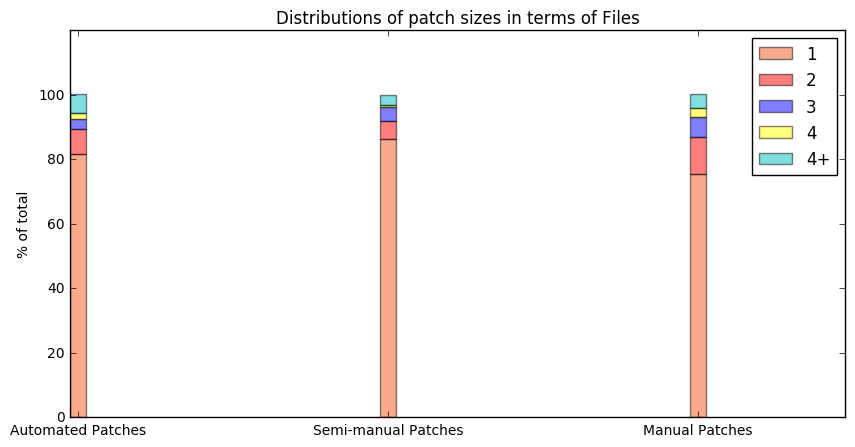

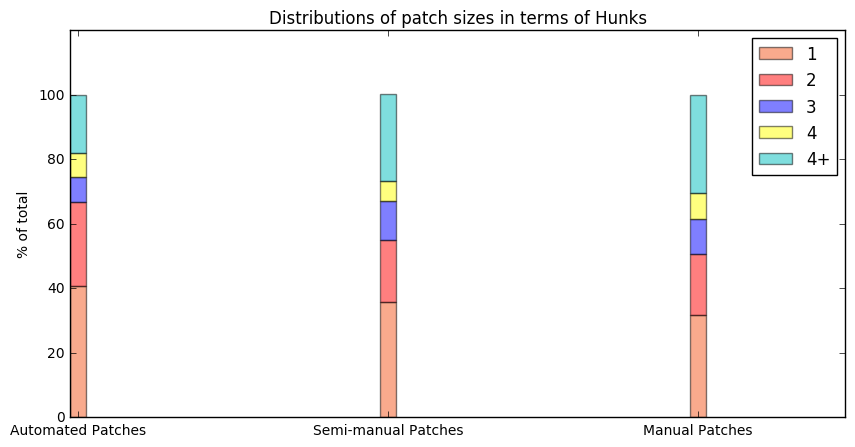

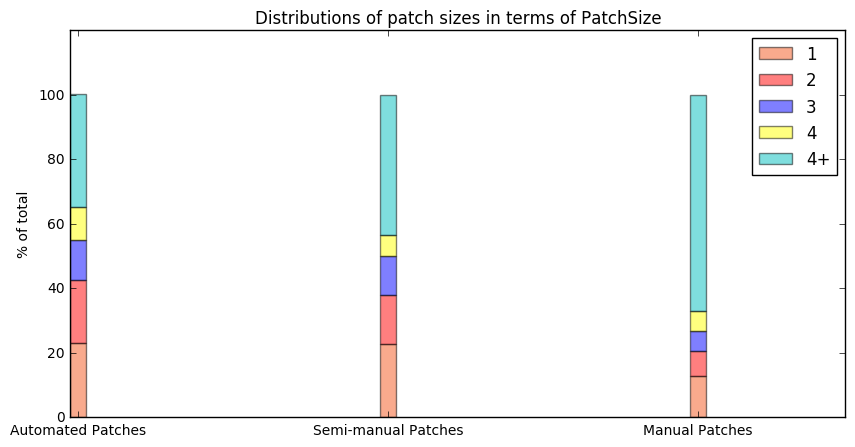